# Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [240]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

## Подготовим данные

In [241]:
try:
    data = pd.read_csv('C:/project/project12/taxi.csv')
except:
    data = pd.read_csv('/datasets/taxi.csv')

In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [243]:
data['datetime'] = data['datetime'].astype('datetime64')

In [244]:
data = data.set_index('datetime')

In [245]:
#отсортируем дадафрейм по индексу
data=data.sort_index()
#проверим, в хронологическом ли порядке расположены даты и время
data.index.is_monotonic

True

In [246]:
#ресемплируем данные по одному часу
data = data.resample('1H').sum()

### Данные готовы для анализа. У данные нет пропусков, они расположены в хронологическом порядке, тип даных в колонке 'datetime' был преобразован во временной формат.

In [247]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


## Анализ данных
### Проведем декомпозицию временного ряда

#### Оценим сезонность по часам внутри каждого дня

In [248]:
decomposed = seasonal_decompose(data)

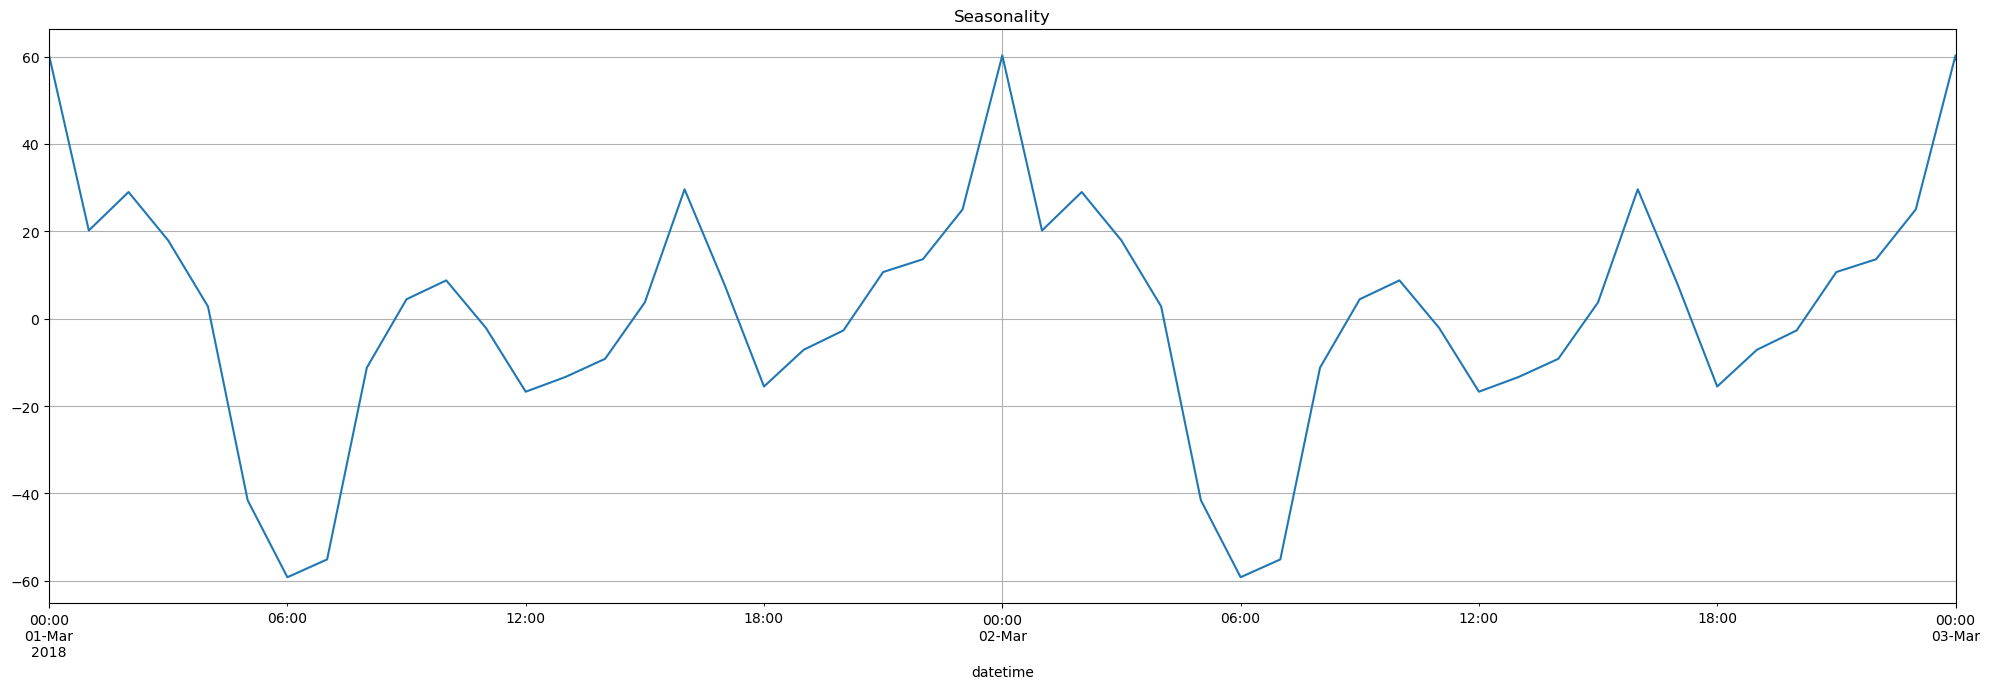

In [249]:
plt.figure(figsize=(20, 7))
plt.subplot(111) #212
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality')
plt.xlim('2018-03-01 00:00:00', '2018-03-03 00:00:00') 
plt.tight_layout()

На графике показаны только два дня, чтобы нагляднее показать сезонность распределения заказов(+- от тренда) внутри одного дня. Можно отметить, что на 6 часов утра количество заказов минимальное (-60 заказов от уровня тренда).

#### Оценим тренд и сезонность по дням

In [250]:
decomposedD = seasonal_decompose(data.resample('1D').sum())

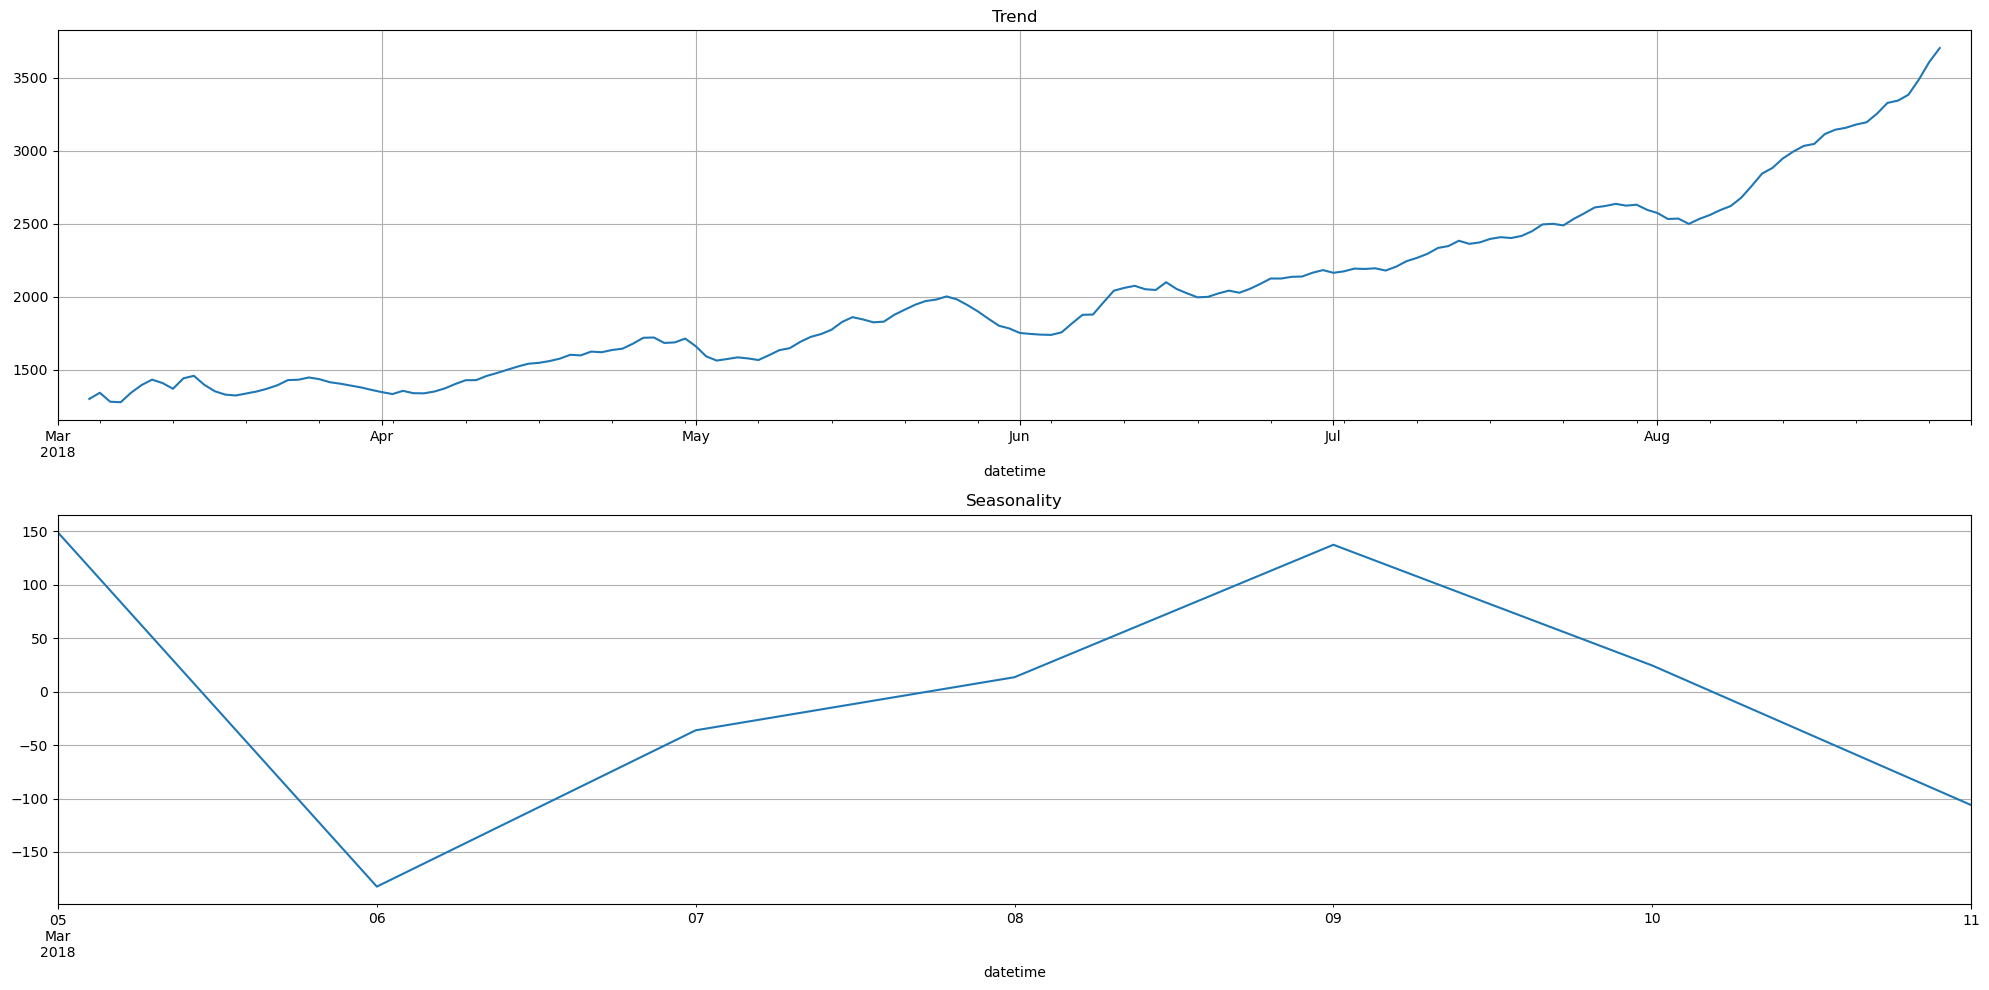

In [251]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
decomposedD.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.subplot(212)
decomposedD.seasonal.plot(ax=plt.gca(), grid=True) 
plt.title('Seasonality')
plt.xlim('2018-03-05', '2018-03-11') # '2018-03-05' - понедельник
plt.tight_layout()

Отметим, что согласно нашим данным, тренд восходящий (в среднем заказов в августе было больше, чем в марте более чем в два раза). Самые загруженные дни недели понедельник и пятница, а самый спокойный день вторник.

### Посмотрим, является ли ряд стационарным.
#### Добавим ряд с разницей текущего значения и предыдущего

In [252]:
data['log'] = data['num_orders'].shift()
data = data.dropna()

In [253]:
data['num_orders_log'] = data['num_orders'] - data['log']

In [254]:
data = data.drop(columns = 'log')

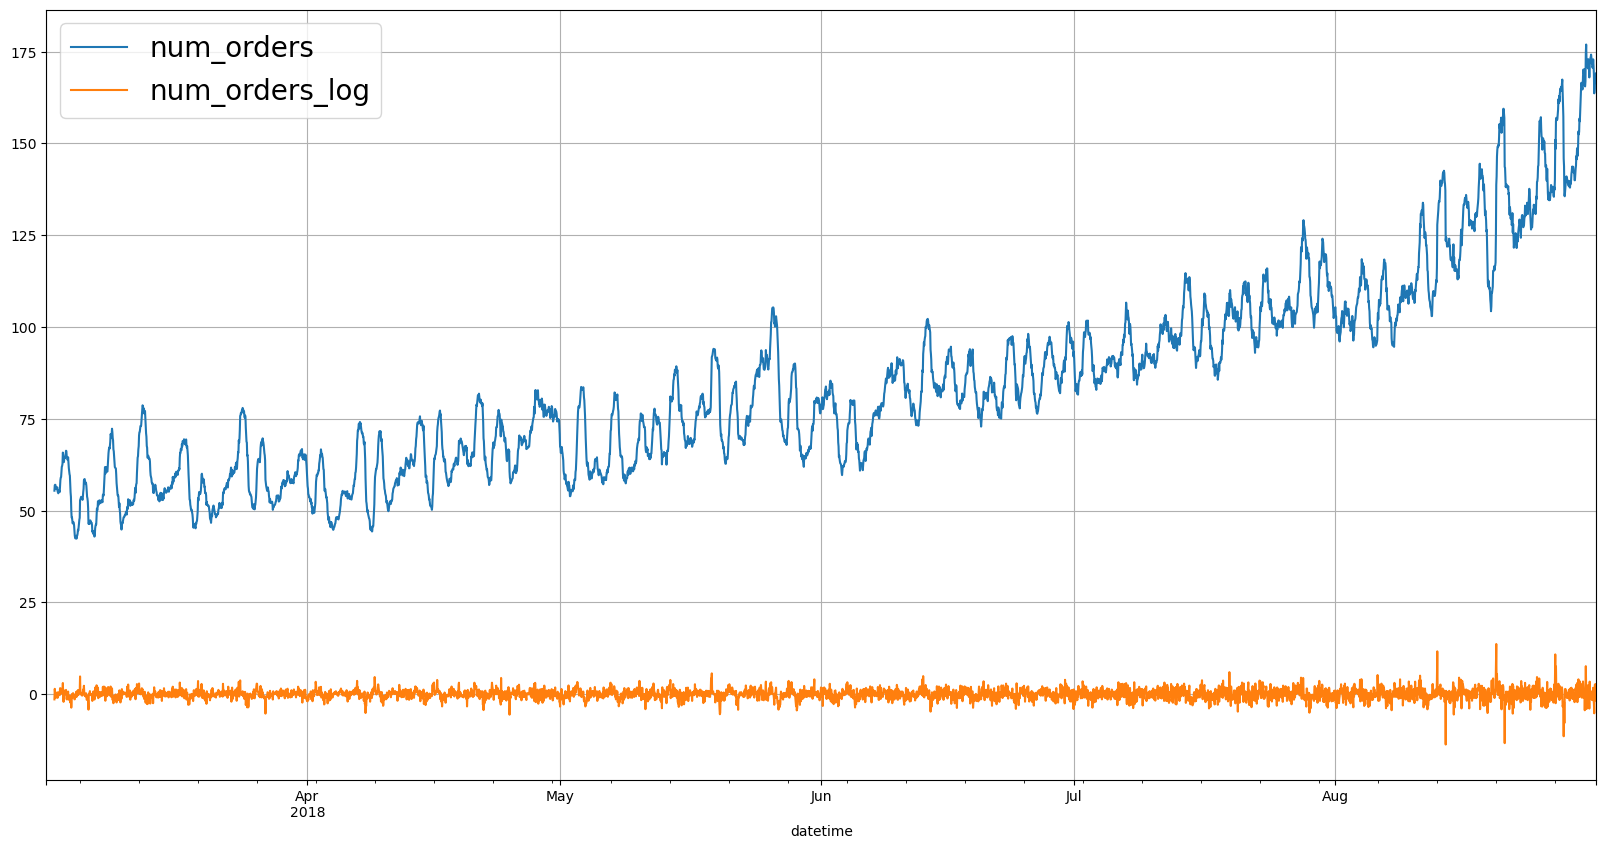

In [255]:
plt.figure(figsize=(20, 10))
ax = data.rolling(24).mean().plot(ax=plt.gca(), grid=True) #24 - интуитивное понятное значение, количество часов в сутках
ax.legend(fontsize = 20)

#### Судя по графику, ряд с данными по количеству заказов, не является стационарным, ясно виден тренд, т.е. увеличение среднего значения. Ряд с разницей значений 100% стационарен, согласно теории, предсказания по нему должны быть более качественные.

## Обучение моделей
### Напишем функцию, которая будет создавать признаки на основе данных временного ряда.

In [256]:
# напишем функцию, которая будет создавать новые признаки
def make_features(data, max_lag, rolling_mean_size):
    temp = data.copy() # будем подбирать параметры max_lag и rolling_mean_size, поэтому необходимо, чтобы старые признаки не сохранялись
    temp['year'] = temp.index.year
    temp['month'] = temp.index.month
    temp['day'] = temp.index.day
    temp['dayofweek'] = temp.index.dayofweek
    
    for lag in range(1, max_lag + 1): # «Отстающие значения» (англ. lag features), будет ли функция x(t) расти или уменьшаться
        temp['lag_{}'.format(lag)] = temp['num_orders'].shift(lag)

    temp['rolling_mean'] = temp['num_orders'].shift().rolling(rolling_mean_size).mean() #Скользящее среднее как признак задаёт общий тренд временного ряда
    # shift() - Вычисление скользящего среднего не должно включать в себя текущее значение ряда. 
    temp = temp.dropna() # для первых записей в результате 'shift' образовались Nan, их надо удалить
    return temp

In [257]:
make_features(data,3,3).head(4)

,num_orders,num_orders_log,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,,
2018-03-01 04:00:00,43,-23.0,2018,3,1,3,66.0,71.0,85.0,74.000000
2018-03-01 05:00:00,6,-37.0,2018,3,1,3,43.0,66.0,71.0,60.000000
2018-03-01 06:00:00,12,6.0,2018,3,1,3,6.0,43.0,66.0,38.333333
2018-03-01 07:00:00,15,3.0,2018,3,1,3,12.0,6.0,43.0,20.333333


### Подберем оптимальные параметры (max_lag, rolling_mean_size) для линейной регрессии с помощью кросс-валидации. В качестве таргета будем использовать колонку 'num_orders', т.е. нестационарный ряд.
Напишем функцию, которая будет подбирать оптимальные параметры по заданной модели по нестационарному ряду (наш изначальный таргет):

In [258]:
def features_param(model, max_lag_range=range(20,30), rolling_mean_range=range(20,30)):
    rmse_opt = 100
    max_lag_opt = 0
    rolling_mean_size_opt = 0

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits) # специальная функция для получения индексов для разбивки временных рядов.
    #важно, чтобы валидационная выборка всегда шла за тренировочной

    for max_lag in max_lag_range:
        for rolling_mean_size in rolling_mean_range:
            df = make_features(data.drop(columns=['num_orders_log']), max_lag, rolling_mean_size)
            train, test = train_test_split(df, shuffle=False, test_size=0.1) # мы не можем перемешивать временные ряды

            feachures_train = train.drop(columns=['num_orders']).reset_index(drop=True)
            target_train = train['num_orders'].reset_index(drop=True)    
            rmse = []
            for fold, (train_index, val_index) in enumerate(tscv.split(feachures_train)):
                X_train, X_val = feachures_train.iloc[train_index], feachures_train.iloc[val_index]
                y_train, y_val = target_train.iloc[train_index], target_train.iloc[val_index] 
                model = model 
                model.fit(X_train, y_train)
                predictions_val = model.predict(X_val)
                rmse.append(mean_squared_error(predictions_val, y_val))   
            final_rmse = (sum(rmse)/len(rmse))**(1/2)   
            if final_rmse < rmse_opt:
                rmse_opt = final_rmse
                max_lag_opt = max_lag
                rolling_mean_size_opt = rolling_mean_size

    print("Кросс-валидация:", 'RMSE:', rmse_opt, 'max_lag_opt:', max_lag_opt, 'rolling_mean_size_opt:', rolling_mean_size_opt)
    
    df = make_features(data.drop(columns=['num_orders_log']), max_lag_opt, rolling_mean_size_opt)
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train = train.dropna()

    feachures_train = train.drop(columns='num_orders')
    target_train = train['num_orders']
    feachures_test = test.drop(columns='num_orders')
    target_test = test['num_orders']

    model = model
    model.fit(feachures_train, target_train)
    predictions_test = model.predict(feachures_test)

    print("RMSE тестовой выборки: ", mean_squared_error(predictions_test, target_test)**(1/2))

In [259]:
features_param(LinearRegression())

Кросс-валидация: RMSE: 26.795962100589325 max_lag_opt: 29 rolling_mean_size_opt: 26
RMSE тестовой выборки:  46.828980518825155


### Подберем оптимальные параметры для линейной регрессии с таргетом 'num_orders_log' (стационарный ряд)
- Напишем функцию, которая будет подбирать оптимальные параметры по заданной модели по стационарному ряду (т.е. мы предсказываем отклонение от предыдущего значения таргета, а в rmse пойдет предикт равный предыдущему значению таргета+предсказанному отклонению
- RMSE будем считать по следующему принципу: (предсказание разницы с предыдущим значением + предыдущее значение), таргет.

In [260]:
def features_param_log(model, max_lag_range=range(20,30), rolling_mean_range=range(20,30)):
    rmse_opt = 100
    max_lag_opt = 0
    rolling_mean_size_opt = 0

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits) # специальная функция для получения индексов для разбивки временных рядов.
    #важно, чтобы валидационная выборка всегда шла за тренировочной

    for max_lag in max_lag_range:
        for rolling_mean_size in rolling_mean_range:
            df = make_features(data, max_lag, rolling_mean_size)
            df['num_orders_1'] = df['num_orders'].shift(1) #выводим предыдущие значения таргета
            # мы будем добавлять его к полученному предсказанию
            df=df.dropna() # удаляем одну запись с Nan
            train, test = train_test_split(df, shuffle=False, test_size=0.1) # мы не можем перемешивать временные ряды

            feachures_train = train.drop(columns=['num_orders', 'num_orders_log', 'num_orders_1']).reset_index(drop=True)
            target_train = train['num_orders_log'].reset_index(drop=True) # таргет, который мы будем предсказывать
            # (разница с предыдущим таргетом) 
            real_target_train = train['num_orders'].reset_index(drop=True) # настоящий таргет
            real_target_train_1 = train['num_orders_1'].reset_index(drop=True) # предыдущее значение таргета 
                      #                                              (по условию задачи, мы его всегда знаем)
                      # это также колонка lag_1 из функции make_features, решил, что надежнее создать отдельный столбец
                                                  
            rmse = []
            for fold, (train_index, val_index) in enumerate(tscv.split(feachures_train)):
                X_train, X_val = feachures_train.iloc[train_index], feachures_train.iloc[val_index]
                y_train, y_val = target_train.iloc[train_index], target_train.iloc[val_index] 
                r_train, r_val = real_target_train.iloc[train_index], real_target_train.iloc[val_index] 
                r1_train, r1_val = real_target_train_1.iloc[train_index], real_target_train_1.iloc[val_index]
                                                  
                model = model 
                model.fit(X_train, y_train)
                predictions_val = model.predict(X_val)
                rmse.append(mean_squared_error((predictions_val+r1_val), r_val))   
            final_rmse = (sum(rmse)/len(rmse))**(1/2)   
            if final_rmse < rmse_opt:
                rmse_opt = final_rmse
                max_lag_opt = max_lag
                rolling_mean_size_opt = rolling_mean_size

    print("Кросс-валидация:", 'RMSE:', rmse_opt, 'max_lag_opt:', max_lag_opt, 'rolling_mean_size_opt:', rolling_mean_size_opt)
    
    
    df = make_features(data, max_lag_opt, rolling_mean_size_opt)
    df['num_orders_1'] = df['num_orders'].shift(1)
    df=df.dropna()
    train, test = train_test_split(df, shuffle=False, test_size=0.1)

    feachures_train = train.drop(columns=['num_orders', 'num_orders_log', 'num_orders_1']).reset_index(drop=True)
    target_train = train['num_orders_log'].reset_index(drop=True) 
    real_target_train = train['num_orders'].reset_index(drop=True)
    real_target_train_1 = train['num_orders_1'].reset_index(drop=True)                                              
    feachures_test = test.drop(columns=['num_orders', 'num_orders_log', 'num_orders_1']).reset_index(drop=True)
    target_test = test['num_orders_log'].reset_index(drop=True) 
    real_target_test = test['num_orders'].reset_index(drop=True)
    real_target_test_1 = test['num_orders_1'].reset_index(drop=True)

    model = model
    model.fit(feachures_train, target_train)
    predictions_test = model.predict(feachures_test)

    print("RMSE тестовой выборки:", mean_squared_error((predictions_test+real_target_test_1), real_target_test)**(1/2))

In [261]:
features_param_log(LinearRegression())

Кросс-валидация: RMSE: 26.778683013899876 max_lag_opt: 25 rolling_mean_size_opt: 28
RMSE тестовой выборки: 46.491493537719094


#### В случае приведения временного ряда к стационарному, RMSE практически не поменялся.

### Подберем оптимальные параметры для модели Lightgbm

#### Нестационарная выборка:

In [262]:
features_param(lgb.LGBMRegressor(random_state=12345))

Кросс-валидация: RMSE: 25.79909282545172 max_lag_opt: 28 rolling_mean_size_opt: 29
RMSE тестовой выборки:  42.51470279252943


#### Стационарная выборка

In [263]:
features_param_log(lgb.LGBMRegressor(random_state=12345))

Кросс-валидация: RMSE: 26.278507756421725 max_lag_opt: 28 rolling_mean_size_opt: 25
RMSE тестовой выборки: 45.57172873878287


#### Модель показывает существенно лучшие результаты на нестационарном ряде. Параметры для формирования оптимального датасета: max_lag_opt: 28 rolling_mean_size_opt: 29.  Попробуем перебрать гиперпараметры модели, чтобы улучшить итоговый результат.

In [264]:
df = make_features(data.drop(columns=['num_orders_log']), 28, 29) # оптимальные параметры для новых фичей
train, test = train_test_split(df, shuffle=False, test_size=0.1)
feachures_train = train.drop(columns=['num_orders']).reset_index(drop=True)
target_train = train['num_orders'].reset_index(drop=True) 

n_splits = 5
tscv = TimeSeriesSplit(n_splits)
rmse_opt = 100
learning_rate_opt = None
n_estimators_opt = None
num_leaves_opt = None

for learning_rate in [0.02, 0.03, 0.04]:
    for n_estimators in np.arange(800, 1110,100):
        for num_leaves in np.arange(6,13,2):
            rmse = []
            for fold, (train_index, val_index) in enumerate(tscv.split(feachures_train)):
                X_train, X_val = feachures_train.iloc[train_index], feachures_train.iloc[val_index]
                y_train, y_val = target_train.iloc[train_index], target_train.iloc[val_index] 
                model = lgb.LGBMRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                num_leaves=num_leaves ,random_state=12345) 
                model.fit(X_train, y_train)
                predictions_val = model.predict(X_val)
                rmse.append(mean_squared_error(predictions_val, y_val))   
            final_rmse = (sum(rmse)/len(rmse))**(1/2)   
            if final_rmse < rmse_opt:
                rmse_opt = final_rmse
                learning_rate_opt = learning_rate
                n_estimators_opt = n_estimators
                num_leaves_opt=num_leaves

print("Кросс-валидация:", 'RMSE:', rmse_opt, 'learning_rate:', learning_rate_opt, 'n_estimators:', n_estimators_opt,
     'num_leaves:', num_leaves_opt)

Кросс-валидация: RMSE: 25.528159248655903 learning_rate: 0.02 n_estimators: 1100 num_leaves: 10


#### При подборе оптимальных параметром, модель стремится к RMSE 25.5. Лучшие параметры: learning_rate: 0.02 n_estimators: 1100 num_leaves: 10
Следует отметить, что n_estimators стремиться в большую сторону, но большого прироста качества это не дает.

In [267]:
feachures_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

model = lgb.LGBMRegressor(learning_rate=0.02, n_estimators=1100,
                num_leaves=10 ,random_state=12345)
model.fit(feachures_train, target_train)
predictions_test = model.predict(feachures_test)

print("RMSE тестовой выборки: ", mean_squared_error(predictions_test, target_test)**(1/2))

RMSE тестовой выборки:  41.45268079372669


#### RMSE тестовой выборки на лучших параметрах модели составила 41.45. Посмотрим на графике, как различаются фактические данные и наши предсказания (последние 2 дня августа)

(426528.0, 426576.0)

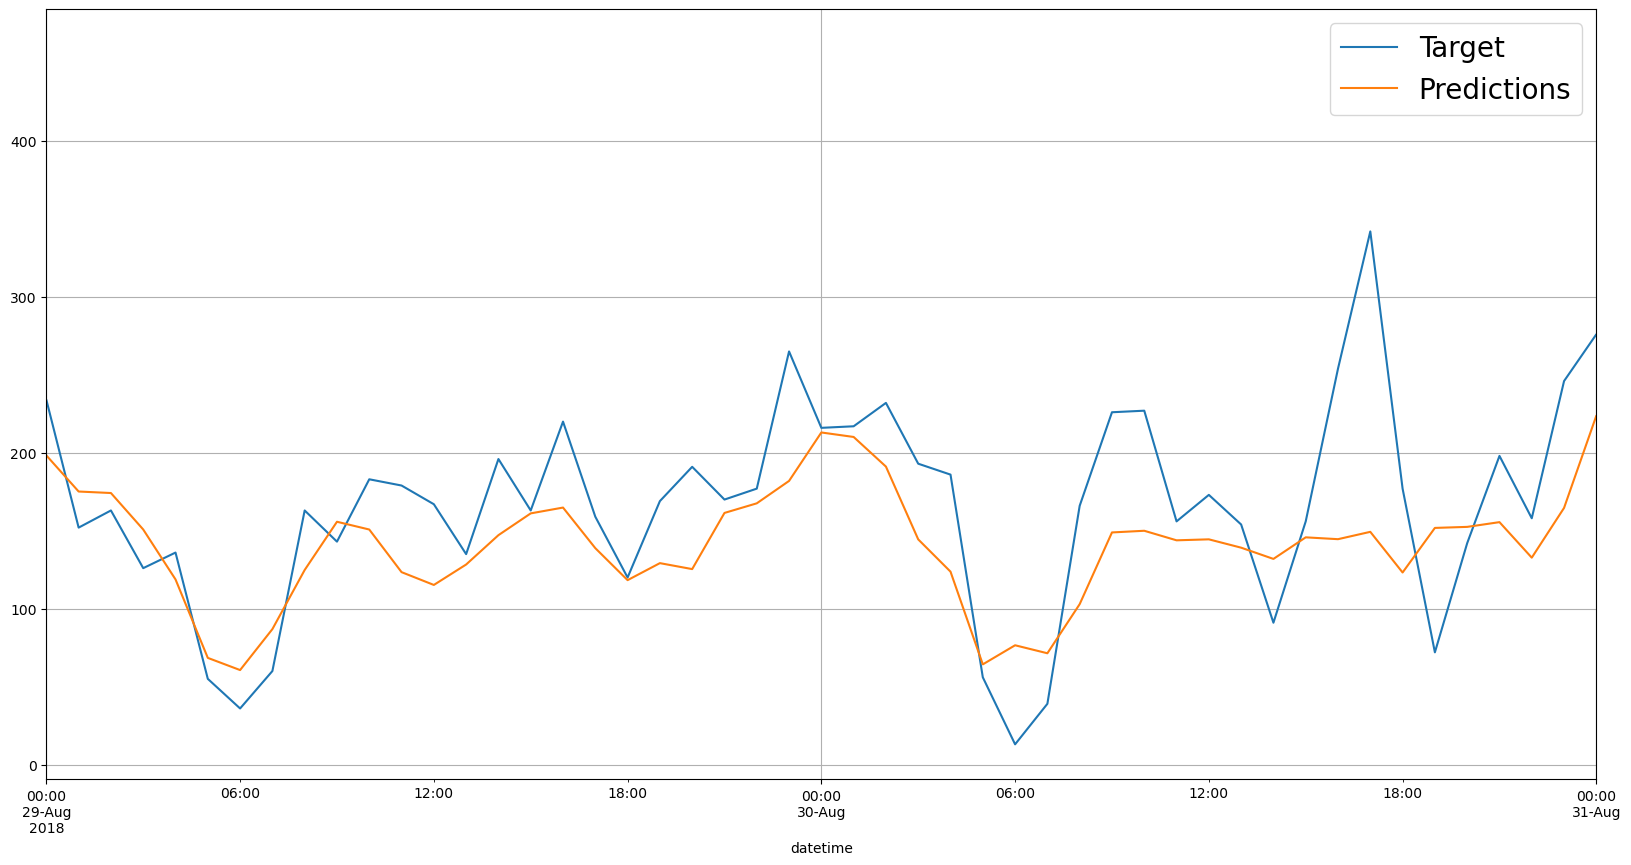

In [266]:
plt.figure(figsize=(20, 10))
graf = pd.DataFrame({'Target':target_test, 'Predictions':predictions_test}, index = target_test.index)
ax = graf.plot(ax=plt.gca(), grid=True)
ax.legend(fontsize = 20)
plt.xlim('2018-08-29', '2018-08-31')

## Выводы
### На обеих моделях удалось уложиться в заданные параметры RMSE (не более 48)
### На тестовой выборке для линейной регрессии удалось достичь RMSE 46.49 на стационарном временном ряде.
### Модель Lightgbm достигла RMSE в 41.45 на нестационарной выборке (изначальные значения таргета).
### Следует отметить, что последние 10-15% выборки отличаются от основной части. Видно изменение тренда и периодически более резкие разницы между соседними значениями (ряд 'num_orders_log'). Поэтому и RMSE тестовой выборки существенно хуже, чем на кросс-валидации.
### Анализируя часть графика, можно отметить, что модель в целом неплохо предсказывает значения. Грубая ошибка приходится на 16-18:00 30 августа (четверг). Вероятно, был какой-то фактор, повлиявший на резкий рост заказов в этот день.